In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare

This code generates a random number distribution over $2\pi$ which takes the shape $crossSect$ and fits it using least squares regression. The purpose of this code is to test the accuracy and precision of using curve fitting to extract a generating parameter of a given data sample. This particular model is taken from nuclear physics, representing a differential cross-section of angles in particle production.

The first step is to generate the random data set. Since the data set must take on any given shape, the set is not generated with a prebuilt function. Instead, a uniform random number distribution is transformed into one of the form $crossSect$ by using the bisection method. To do so, I generated a probability density function $probDensity$ through the following formula:

$\rho(\phi) = \int_{0}^{\phi} crossSect \,d\phi' $

which, in this case, with a $crossSect$ of $\frac{\partial \sigma}{\partial \Omega} = 1 - \Sigma cos(2\phi)$ is

$\rho(\phi) = \phi - \frac{1}{2}\Sigma sin(2\phi)$

Setting the probability density equal to a random number $r$ from a uniform distribution and solving for $\phi$ using the bisection method generates an angle $\phi$ whose relative probability obeys the formula for $crossSect$.

In [52]:
def crossSect(phi,sigma):                                               #Functions are defined for each step to simplify later
    return 1 - sigma*np.cos(2*phi)                                      #analysis steps. These first two are the cross section
                                                                        #and probability density of the distribution.
def probDensity(guessphi, sigma):
    return (2*guessphi - sigma*np.sin(2*guessphi))/2

def getSimData(sigma,N):                                                #This function generates the data set. 
    bound = 0.00001                                                     #The first step is setting a bound for the bisection,
    phis = list()                                                       #an arbitrary choice. Next, a list is set for the phis.
    n = 1
    while(n <= N):                                                      #This while loop is where the bisection happens for each
            r = random.random()*2*np.pi                                 #random number. The numbers are uniformly randomly
            upperphi = 2*np.pi                                          #generated from 0 to 2pi. Upper and lower bounds for
            lowerphi = 0                                                #bisection are set here as well. guessphi is the
            guessphi = 0.5*(upperphi + lowerphi)                        #midpoint of lowerphi and upperphi.
            magnitude = abs(probDensity(guessphi, sigma) - r)           #magnitude is the difference of the random number and
            while(magnitude > bound):                                   #the probability density at the midpoint.
                bestguess = probDensity(guessphi, sigma)                #bestguess is the probability density at the midpoint.
                if(bestguess < r):                                      #Depending on the relative values of r and bestguess,
                    lowerphi = guessphi                                 #the bounds are changed. This is just normal bisection.
                    guessphi = 0.5*(upperphi + lowerphi)
                elif(bestguess > r):
                    upperphi = guessphi
                    guessphi = 0.5*(upperphi + lowerphi)
                elif(bestguess == r):                                   #These two statements are only for debugging. The first
                    print("Bolognese")                                  #is triggered if r is the midpoint, which is not covered
                    break                                               #by the first two sorting blocks. The next breaks the
                else:                                                   #simulation if, somehow, none of the above statements
                    print("Error")                                      #are true. This should be impossible.
                    break
                magnitude = abs(probDensity(guessphi, sigma) - r)       #magnitude is recalculated here.
            phis.append(guessphi)                                       #the new phi value is added to the list of phis.
            n = n + 1
    return phis

sigma = 0.73                                                            #The necessary values are provided and the function is
N = 30233                                                               #called. These values can be changed, as needed.
phis = getSimData(sigma,N)
print("Done!")

Done!


In [53]:
def getHist(phis,NBins):                                                             #This function bins the values of phi in a
    BinWidth = (2*np.pi)/NBins                                                       #histogram. The bins are even subdivisions
    phicounts, bin_edges= np.histogram(phis, bins=np.arange(0, 2*np.pi, BinWidth))   #2pi. The histogramming is done through
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2                            #numpy. The bin centers are then calculated
    return phicounts, bin_centers                                                    #and put in a vector for use as phi values
                                                                                     #for each bin.
NBins = 200
phicounts, bin_centers = getHist(phis,NBins)
print("Done!")

Done!


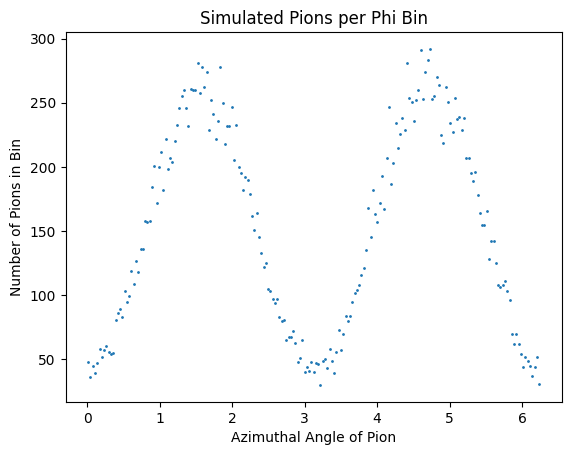

In [54]:
ax = plt.subplot()                                    #This part of the code just plots the scatter plot of binned data.
ax.scatter(bin_centers,phicounts, 1)
ax.set_title("Simulated Pions per Phi Bin")
ax.set_xlabel('Azimuthal Angle of Pion')
ax.set_ylabel('Number of Pions in Bin')
plt.show()

In [55]:
def BSAFit(phicounts,bin_centers,N0):                              #This function is the function which fits the data.
    initGuess = [0.5]                                              #The initial guess can be anything, this case is 1 parameter.
    i = 0                                                          #Initialize counting variable.
    phicounts_mod = phicounts / N0                                 #In order to convert the frequency to a differential cross
    phiuncs = list()                                               #section, divide by the constant N0 defined below.
    while(i < len(phicounts_mod)):                                 #This while loop constructs uncertainties on each phi point
        phiuncs.append(np.sqrt(phicounts_mod[i]))                  #equal to the square root of the counts; poisson uncertainty.
        i = i + 1
    sigma_exp, sigma_covar = curve_fit(crossSect, bin_centers, phicounts_mod, p0=initGuess,sigma=phiuncs,absolute_sigma=True)
    sigma_err = np.sqrt(np.diag(sigma_covar))                      #The square root of the covariance matrix gives an
    return sigma_exp,sigma_err,phiuncs                             #uncertainty on each parameter in the fit.

def getChiSq(Ys,Uncs,FYs):                                         #This function obtains the chi^2 value for a given vector of
    chisq = 0                                                      #y values, uncertainties on those values, and y values of a
    for i in range(0,len(Ys)):                                     #function.
        chisq = chisq + ((Ys[i]-FYs[i])/Uncs[i])**2
    return chisq

N0 = N/NBins                                                       #The normalization parameter N0 is calculated here.
sigma_exp,sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
phicounts_exp = list()
for i in range(0,len(phicounts)):
    phicounts_exp.append(N0*crossSect((bin_centers[i]),sigma_exp)) #This process generates a list of fit function values for
    phiuncs[i] = np.sqrt(N0)*phiuncs[i]                            #each phi bin, and the de-normalized uncertainty on each bin.
chisq = getChiSq(phicounts,phiuncs,phicounts_exp)
print("The results of the fit")
print("  The estimated Sigma Beam Spin Asymmetry is {0:.3g} +/- {1:.3g}".format(sigma_exp[0],sigma_err[0]))
print("  The chi-squared value for this fit is",chisq)

The results of the fit
  The estimated Sigma Beam Spin Asymmetry is 0.736 +/- 0.0762
  The chi-squared value for this fit is [194.2791635]


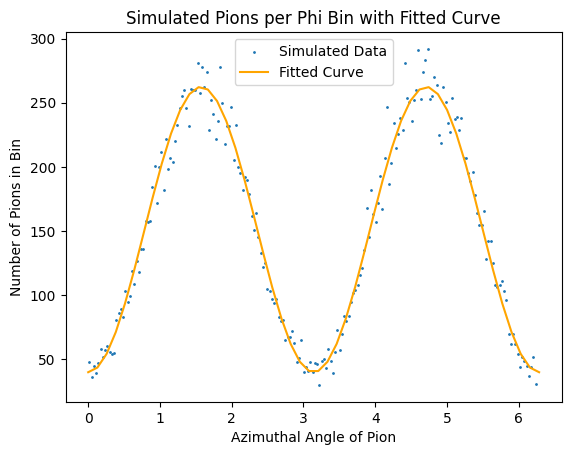

In [56]:
ax1 = plt.subplot()                                              #Graph the scatter plot again, this time with the fitted curve.
ax1.scatter(bin_centers,phicounts, 1)
phi = np.linspace(0,2*np.pi,50)
ax1.plot(phi,N0*crossSect(phi,sigma_exp),color='orange')
ax1.set_title('Simulated Pions per Phi Bin with Fitted Curve')
ax1.set_xlabel('Azimuthal Angle of Pion')
ax1.set_ylabel('Number of Pions in Bin')
ax1.legend(['Simulated Data','Fitted Curve'])
plt.show()

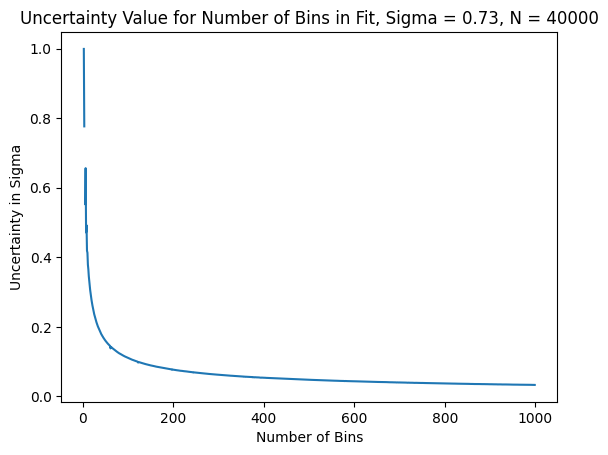

In [36]:
def binUncertainty(sigma,N):                                           #This function runs through the process of fit generating
    NBins = 2                                                          #while varying the number of phi bins. It provides the
    sigma_exps = list()                                                #uncertainty on the fit parameter for each, allowing
    sigma_errs = list()                                                #investigation of uncertainty behavior as NBins varies.
    NBins_list = list()
    phis = getSimData(sigma,N)
    while(NBins < 1000):
        N0 = N/NBins
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        sigma_errs.append(sigma_err)
        NBins_list.append(NBins)
        NBins = NBins + 1
    return sigma_exps,sigma_errs,NBins_list

sigma_exps_bins,sigma_errs_bins,NBins_list = binUncertainty(sigma = 0.73,N = 40000)
ax = plt.subplot()
ax.plot(NBins_list,sigma_errs_bins)
ax.set_title('Uncertainty Value for Number of Bins in Fit, Sigma = 0.73, N = 40000')
ax.set_xlabel('Number of Bins')
ax.set_ylabel('Uncertainty in Sigma')
plt.show()

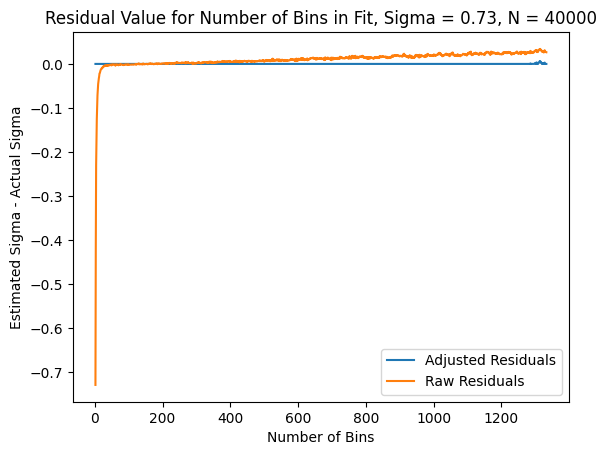

In [34]:
def binResiduals(sigma,N):                                                 #This function works similarly to the above but tests
    NBins = 2                                                              #the accuracy of the fit; i.e. how well the fit
    sigma_exps = list()                                                    #returns the parameter sigma used to generate the
    sigma_resids = list()                                                  #distribution.
    sigma_resids_raw = list()
    NBins_list = list()
    phis = getSimData(sigma,N)
    while(NBins < N/30):
        N0 = N/NBins
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        NBins_list.append(NBins)
        if((sigma_exp - sigma_err) > sigma):                               #This section creates the "adjusted residual." It is
            sigma_resid = (sigma_exp[0]-sigma_err[0]) - sigma              #zero if the actual is inside the error bars of the
        elif((sigma_exp - sigma_err) < sigma and (sigma_exp + sigma_err) > sigma):
            sigma_resid = 0                                                #estimate, else it is the difference between the
        else:                                                              #closest value within the estimate uncertainty and
            sigma_resid = (sigma_exp[0]+sigma_err[0]) - sigma              #the actual value.
        sigma_resids.append(sigma_resid)
        sigma_resids_raw.append(sigma_exp[0]-sigma)                        #This "raw" residual is the difference between the
        NBins = NBins + 1                                                  #estimate and the actual sigma.
    return sigma_exps,sigma_resids,sigma_resids_raw,NBins_list

sigma_exps_bins,sigma_resids_bins,sigma_resids_raw_bins,NBins_list = binResiduals(sigma = 0.73,N = 40000)
ax = plt.subplot()
ax.plot(NBins_list,sigma_resids_bins)
ax.plot(NBins_list,sigma_resids_raw_bins)
ax.set_title('Residual Value for Number of Bins in Fit, Sigma = 0.73, N = 40000')
ax.set_xlabel('Number of Bins')
ax.set_ylabel('Estimated Sigma - Actual Sigma')
ax.legend(['Adjusted Residuals','Raw Residuals'])
plt.show()

C:\Users\Logan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Logan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


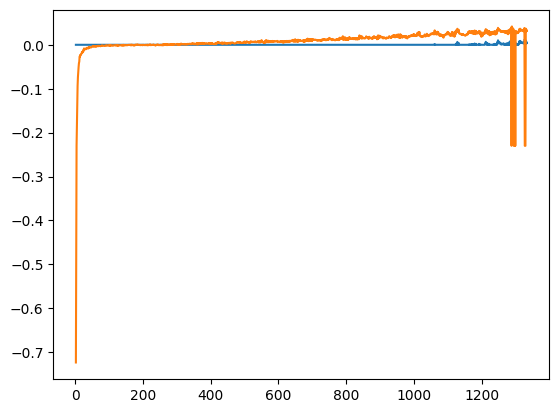

In [57]:
def binResiduals(sigma,N):
    NBins = 2
    sigma_exps = list()
    sigma_resids = list()
    sigma_resids_raw = list()
    NBins_list = list()
    phis = getSimData(sigma,N)
    while(NBins < N/30):
        N0 = N/NBins
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        NBins_list.append(NBins)
        if((sigma_exp - sigma_err) > sigma):
            sigma_resid = (sigma_exp[0]-sigma_err[0]) - sigma
        elif((sigma_exp - sigma_err) < sigma and (sigma_exp + sigma_err) > sigma):
            sigma_resid = 0
        else:
            sigma_resid = (sigma_exp[0]+sigma_err[0]) - sigma
        sigma_resids.append(sigma_resid)
        sigma_resids_raw.append(sigma_exp[0]-sigma)
        NBins = NBins + 1
    return sigma_exps,sigma_resids,sigma_resids_raw,NBins_list

sigma_exps_bins,sigma_resids_bins,sigma_resids_raw_bins,NBins_list = binResiduals(sigma = 0.73,N = 40000)
ax = plt.subplot()
ax.plot(NBins_list,sigma_resids_bins)
ax.plot(NBins_list,sigma_resids_raw_bins)
plt.show()

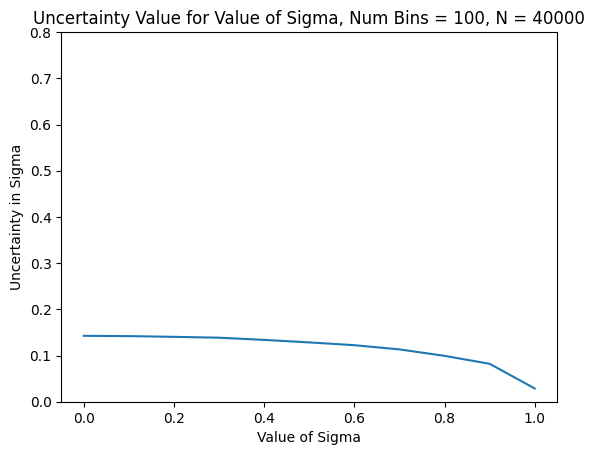

In [37]:
def sigmaUncertainty(NBins,N):                        #This does the same thing as the previous uncertainty function for NBins,
    sigma = 0                                         #but this time varying the parameter sigma to test dependence on that.
    sigma_exps = list()
    sigma_errs = list()
    sigmas_list = list()
    N0 = N/NBins
    while(sigma < 1):
        phis = getSimData(sigma,N)
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        sigma_errs.append(sigma_err)
        sigmas_list.append(sigma)
        sigma = sigma + 0.1
    return sigma_exps,sigma_errs,sigmas_list

sigma_exps_sigmas,sigma_errs_sigmas,sigmas_list = sigmaUncertainty(NBins = 100,N = 40000)
ax = plt.subplot()
ax.plot(sigmas_list,sigma_errs_sigmas)
ax.set_ylim(0,0.8)
ax.set_title('Uncertainty Value for Value of Sigma, Num Bins = 100, N = 40000')
ax.set_xlabel('Value of Sigma')
ax.set_ylabel('Uncertainty in Sigma')
plt.show()

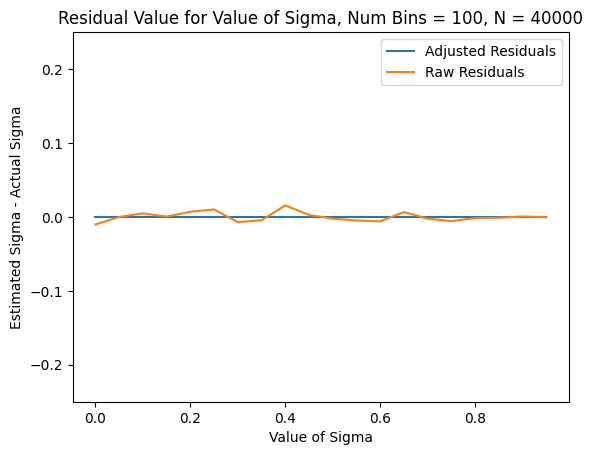

In [38]:
def sigmaResiduals(NBins,N):                                                   #Same as above, but for residuals.
    sigma = 0
    sigma_exps = list()
    sigma_resids = list()
    sigma_resids_raw = list()
    sigmas_list = list()
    N0 = N/NBins
    while(sigma < 1):
        phis = getSimData(sigma,N)
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        if((sigma_exp - sigma_err) > sigma):
            sigma_resid = (sigma_exp[0]-sigma_err[0]) - sigma
        elif((sigma_exp - sigma_err) < sigma and (sigma_exp + sigma_err) > sigma):
            sigma_resid = 0
        else:
            sigma_resid = (sigma_exp[0]+sigma_err[0]) - sigma
        sigma_resids.append(sigma_resid)
        sigma_resids_raw.append(sigma_exp[0]-sigma)
        sigmas_list.append(sigma)
        sigma = sigma + 0.05
    return sigma_exps,sigma_resids,sigma_resids_raw,sigmas_list

sigma_exps_sigmas,sigma_resids_sigmas,sigma_resids_raw_sigmas,sigmas_list = sigmaResiduals(NBins = 100,N = 40000)
ax = plt.subplot()
ax.plot(sigmas_list,sigma_resids_sigmas)
ax.plot(sigmas_list,sigma_resids_raw_sigmas)
ax.set_ylim(-0.25,0.25)
ax.set_title('Residual Value for Value of Sigma, Num Bins = 100, N = 40000')
ax.set_xlabel('Value of Sigma')
ax.set_ylabel('Estimated Sigma - Actual Sigma')
ax.legend(['Adjusted Residuals','Raw Residuals'])
plt.show()

In [39]:
phis_tot = getSimData(sigma,500000)                #This block generates a huge set of simulated data for estimating uncertainty
print('Done!')                                     #and residuals on number of events, to save time.

Done!


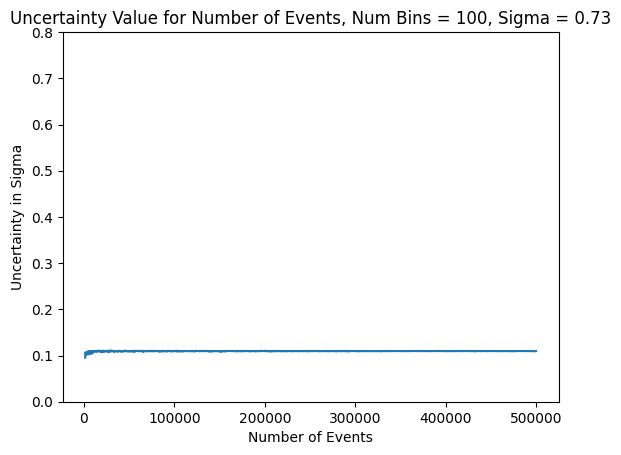

In [41]:
def NUncertainty(sigma,NBins,phis_tot):            #This functions identically to the previous code blocks about uncertainties,
    N = 400                                        #but saves time by drawing a random entry from the big list of generated phi
    index = 0                                      #values.
    sigma_exps = list()
    sigma_errs = list()
    Ns_list = list()
    while(N < 500000):
        N0 = N/NBins
        phis = list()
        i = 0
        while(i < N):
            phis.append(phis_tot[int(random.random()*500000)]) #This line appends a random value from the big phis list to the
            i = i + 1                                          #list used in the fitting for this value of N.
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        sigma_errs.append(sigma_err)
        Ns_list.append(N)
        index = index + 1
        N = N + 400
    return sigma_exps,sigma_errs,Ns_list

sigma_exps_Ns,sigma_errs_Ns,Ns_list = NUncertainty(sigma = 0.73,NBins = 100,phis_tot=phis_tot)
ax = plt.subplot()
ax.plot(Ns_list,sigma_errs_Ns)
ax.set_ylim(0,0.8)
ax.set_title('Uncertainty Value for Number of Events, Num Bins = 100, Sigma = 0.73')
ax.set_xlabel('Number of Events')
ax.set_ylabel('Uncertainty in Sigma')
plt.show()

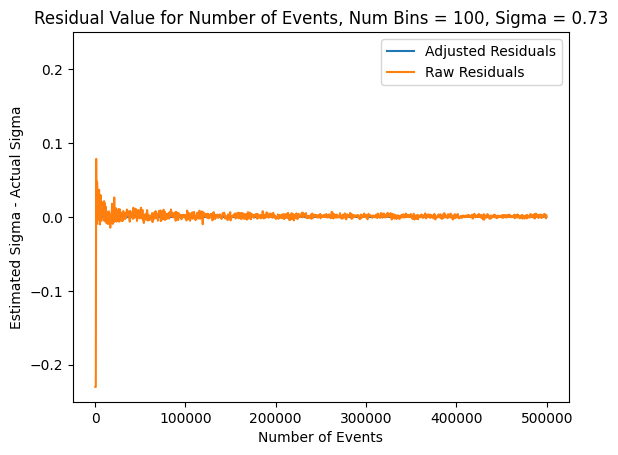

In [42]:
def NResiduals(sigma,NBins,phis_tot):                                      #Exact same as above but for residuals this time.
    N = 400
    index = 0
    sigma_exps = list()
    sigma_resids = list()
    sigma_resids_raw = list()
    Ns_list = list()
    while(N < 500000):
        N0 = N/NBins
        phis = list()
        i = 0
        while(i < N):
            phis.append(phis_tot[int(random.random()*500000)])
            i = i + 1
        phicounts, bin_centers = getHist(phis,NBins)
        sigma_exp, sigma_err,phiuncs = BSAFit(phicounts,bin_centers,N0)
        sigma_exps.append(sigma_exp)
        if((sigma_exp - sigma_err) > sigma):
            sigma_resid = (sigma_exp[0]-sigma_err[0]) - sigma
        elif((sigma_exp - sigma_err) < sigma and (sigma_exp + sigma_err) > sigma):
            sigma_resid = 0
        else:
            sigma_resid = (sigma_exp[0]+sigma_err[0]) - sigma
        sigma_resids.append(sigma_resid)
        sigma_resids_raw.append(sigma_exp[0]-sigma)
        Ns_list.append(N)
        index = index + 1
        N = N + 400
    return sigma_exps,sigma_resids,sigma_resids_raw,Ns_list

sigma_exps_Ns,sigma_resids_Ns,sigma_resids_raw_Ns,Ns_list = NResiduals(sigma = 0.73,NBins = 100,phis_tot=phis_tot)
ax = plt.subplot()
ax.plot(Ns_list,sigma_resids_Ns)
ax.plot(Ns_list,sigma_resids_raw_Ns)
ax.set_ylim(-0.25,0.25)
ax.set_title('Residual Value for Number of Events, Num Bins = 100, Sigma = 0.73')
ax.set_xlabel('Number of Events')
ax.set_ylabel('Estimated Sigma - Actual Sigma')
ax.legend(['Adjusted Residuals','Raw Residuals'])
plt.show()

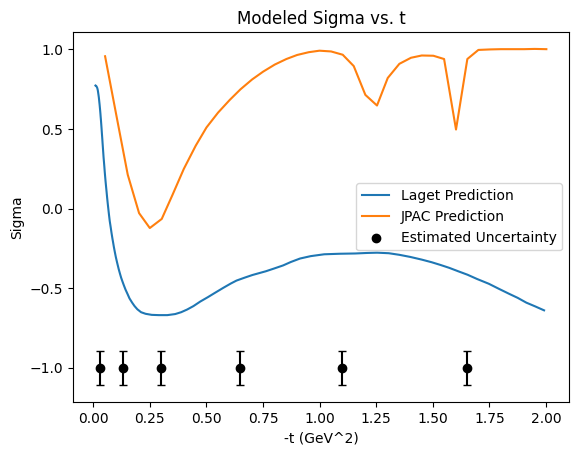

In [43]:
Laget_t,Laget_sigma = np.loadtxt(r'BSAvT_Laget.csv', unpack=True)
JPAC_t,JPAC_sigma = np.loadtxt(r'BSAvT_JPAC.csv', unpack=True)
fig,ax = plt.subplots()
ax.plot(Laget_t,Laget_sigma)
ax.plot(-JPAC_t,JPAC_sigma)
ax.errorbar(0.03,-1,yerr=0.107,color='black',capsize=3)
ax.scatter(0.03,-1,color='black')
ax.errorbar(0.13,-1,yerr=0.107,color='black',capsize=3)
ax.scatter(0.13,-1,color='black')
ax.errorbar(0.3,-1,yerr=0.108,color='black',capsize=3)
ax.scatter(0.3,-1,color='black')
ax.errorbar(0.65,-1,yerr=0.107,color='black',capsize=3)
ax.scatter(0.65,-1,color='black')
ax.errorbar(1.1,-1,yerr=0.107,color='black',capsize=3)
ax.scatter(1.1,-1,color='black')
ax.errorbar(1.65,-1,yerr=0.106,color='black',capsize=3)
ax.scatter(1.65,-1,color='black')
ax.set_title('Modeled Sigma vs. t')
ax.set_xlabel('-t (GeV^2)')
ax.set_ylabel('Sigma')
ax.legend(['Laget Prediction','JPAC Prediction','Estimated Uncertainty'])
plt.show()

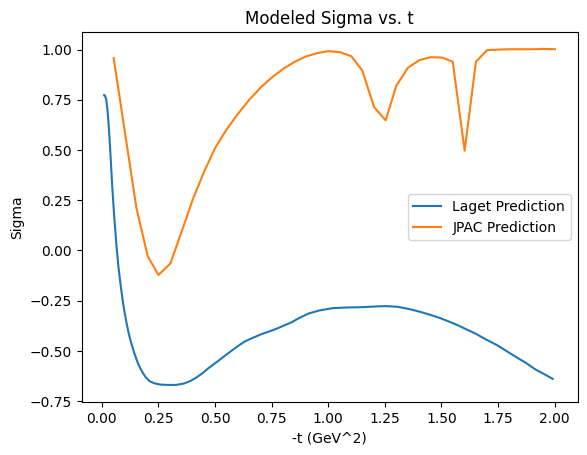

In [51]:
Laget_t,Laget_sigma = np.loadtxt(r'BSAvT_Laget.csv', unpack=True)
JPAC_t,JPAC_sigma = np.loadtxt(r'BSAvT_JPAC.csv', unpack=True)
fig,ax = plt.subplots()
ax.plot(Laget_t,Laget_sigma)
ax.plot(-JPAC_t,JPAC_sigma)
ax.set_title('Modeled Sigma vs. t')
ax.set_xlabel('-t (GeV^2)')
ax.set_ylabel('Sigma')
ax.legend(['Laget Prediction','JPAC Prediction','Estimated Uncertainty'])
plt.show()